### Predição de notas de filmes -  Aprendizado de Máquina

In [30]:
#Import de bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

#### Leitura do arquivo

In [2]:
df = pd.read_csv('dataset_modelo_ml.csv',sep=',')

In [63]:
#Validação

df_filme = pd.read_csv('teste_ml.csv',sep=',')

#### Pré - processamento dos dados

#### Coluna de gênero

Para preparar a variável categórica 'Gênero' para a modelagem, foi adotada uma estratégia de engenharia de features orientada pelos resultados da Análise Exploratória de Dados (EDA). Os cinco gêneros mais representativos foram identificados e transformados em colunas binárias distintas através da técnica de one-hot encoding. Com o objetivo de reduzir a dimensionalidade e agrupar as categorias de baixa frequência, todos os gêneros restantes foram consolidados em uma única coluna chamada 'Outros'.

In [3]:
#### Coluna de gênero

# Conforme aplica na EDA para capturar os gêneros distintos, será aplicado ao mesmo código para realizar a divisão
df['Genre_split'] = df['Genre'].str.split(',')
df_generos_separados = df.explode('Genre_split')
df_generos_separados['Genre_split'] = df_generos_separados['Genre_split'].str.strip()

# Separa a frequencia dos top
freq_generos = df_generos_separados['Genre_split'].value_counts()
top5_freq = freq_generos.head(5).index.tolist()

# Função para criar nome das nova colunas
def _slug(txt):
    return re.sub(r'\W+', '_', txt.strip().lower()).strip('_')

# Verifica se existe a coluna 
# convert lista para set
df['Genre_set'] = df['Genre_split'].apply(
    lambda lst: set(g.strip() for g in lst) if isinstance(lst, list) else set()
)

# Acumula os nomes das colunas criadas
top_cols = []
for g in top5_freq:
    col = f"gen_{_slug(g)}"
    df[col] = df['Genre_set'].apply(lambda s: int(g in s))
    top_cols.append(col)

# Classifica em binário
df['gen_outros'] = (df[top_cols].sum(axis=1) == 0).astype(int)
print(top5_freq)


['Drama', 'Comedy', 'Crime', 'Adventure', 'Action']


In [65]:
#Validação
#### Coluna de gênero

# Conforme aplica na EDA para capturar os gêneros distintos, será aplicado ao mesmo código para realizar a divisão
df_filme['Genre_split'] = df_filme['Genre'].str.split(',')
df_generos_separados = df_filme.explode('Genre_split')
df_generos_separados['Genre_split'] = df_generos_separados['Genre_split'].str.strip()

# Separa a frequencia dos top
freq_generos = df_generos_separados['Genre_split'].value_counts()
top5_freq = freq_generos.head(5).index.tolist()

# Função para criar nome das nova colunas
def _slug(txt):
    return re.sub(r'\W+', '_', txt.strip().lower()).strip('_')

# Verifica se existe a coluna 
# convert lista para set
df_filme['Genre_set'] = df_filme['Genre_split'].apply(
    lambda lst: set(g.strip() for g in lst) if isinstance(lst, list) else set()
)

# Acumula os nomes das colunas criadas
top_cols = []
for g in top5_freq:
    col = f"gen_{_slug(g)}"
    df_filme[col] = df_filme['Genre_set'].apply(lambda s: int(g in s))
    top_cols.append(col)

# Classifica em binário
df_filme['gen_outros'] = (df_filme[top_cols].sum(axis=1) == 0).astype(int)
print(top5_freq)


['Drama']


#### Classificação etária

Seguindo a mesma estratégia aplicada aos gêneros, a variável Certificate_Atualizado foi otimizada para a modelagem. Com o objetivo de reduzir a dimensionalidade e agrupar as classificações de baixa frequência identificadas na EDA, foram selecionadas duas categorias mais prevalentes (maiores de 18 e livre). Estas, juntamente com uma categoria agregada 'Outros' para as demais, foram então convertidas em um formato numérico utilizando a técnica de one-hot encoding, resultando em quatro novas colunas binárias.

In [4]:
#### Classificação etária

# Normaliza texto da classificação
cert_raw = (df["Certificate_Atualizado"].astype("string").str.lower().str.strip())

# Extrai o número da idade  e "livre" vira 0
age_num = pd.to_numeric(cert_raw.str.extract(r"(\d+)", expand=False), errors="coerce")
is_livre = cert_raw.str.contains("livre", na=False)
age_num = age_num.mask(is_livre & age_num.isna(), 0)

# Classifica em binário 
mask_maior18 = age_num.ge(18)
mask_livre   = age_num.eq(0)

# Cria colunas binárias
df["class_maior_18"] = mask_maior18.fillna(False).astype("Int8")
df["class_livre"]    = mask_livre.fillna(False).astype("Int8")
df["class_outros"]   = (~(mask_maior18 | mask_livre)).fillna(True).astype("Int8")


In [66]:
#Validação
#### Classificação etária

# Normaliza texto da classificação
cert_raw = (df_filme["Certificate_Atualizado"].astype("string").str.lower().str.strip())

# Extrai o número da idade  e "livre" vira 0
age_num = pd.to_numeric(cert_raw.str.extract(r"(\d+)", expand=False), errors="coerce")
is_livre = cert_raw.str.contains("livre", na=False)
age_num = age_num.mask(is_livre & age_num.isna(), 0)

# Classifica em binário 
mask_maior18 = age_num.ge(18)
mask_livre   = age_num.eq(0)

# Cria colunas binárias
df_filme["class_maior_18"] = mask_maior18.fillna(False).astype("Int8")
df_filme["class_livre"]    = mask_livre.fillna(False).astype("Int8")
df_filme["class_outros"]   = (~(mask_maior18 | mask_livre)).fillna(True).astype("Int8")


#### Runtime

A coluna tempo de duração 'Runtime' foi transformada de numérica para categórica. Com base na distribuição estatística dos dados (mín: 45, Q1: 103, mediana: 119, Q3: 137, máx: 321), os filmes foram agrupados em quatro faixas de duração para simplificar a aplicação e melhorar a performance dos modelos

In [7]:
# Runtime

# Define faixas e rótulos 
bins   = [0, 103, 119, 135, 321]
labels = ['Curto', 'Medio', 'Longo', 'Muito longo']

# Cria uma nova coluna
df['Runtime_Class'] = pd.cut(df['Runtime'],bins=bins, labels=labels, right=True,include_lowest=True)

# Separa a coluna criada em binário
dummies = pd.get_dummies(df['Runtime_Class'], prefix='runtime', prefix_sep='_', dtype='int8')

# Aplica os indez
expected = ['runtime_Curto', 'runtime_Medio', 'runtime_Longo', 'runtime_Muito longo']
dummies = dummies.reindex(columns=expected, fill_value=0)
df = pd.concat([df, dummies], axis=1)


In [68]:
# Validação
# Runtime

# Define faixas e rótulos 
bins   = [0, 103, 119, 135, 321]
labels = ['Curto', 'Medio', 'Longo', 'Muito longo']

# Cria uma nova coluna
df_filme['Runtime_Class'] = pd.cut(df_filme['Runtime'],bins=bins, labels=labels, right=True,include_lowest=True)

# Separa a coluna criada em binário
dummies = pd.get_dummies(df_filme['Runtime_Class'], prefix='runtime', prefix_sep='_', dtype='int8')

# Aplica os indez
expected = ['runtime_Curto', 'runtime_Medio', 'runtime_Longo', 'runtime_Muito longo']
dummies = dummies.reindex(columns=expected, fill_value=0)
df_filme = pd.concat([df_filme, dummies], axis=1)


In [8]:
df['Runtime'].describe()

count    999.000000
mean     122.871872
std       28.101227
min       45.000000
25%      103.000000
50%      119.000000
75%      137.000000
max      321.000000
Name: Runtime, dtype: float64

#### Releasead Year

Para capturar tendências geracionais, a feature contínua 'Ano de Lançamento' foi discretizada. O período foi segmentado pelo  intervalo de 100 anos coberto pelo dataset em quatro períodos categóricos de 25 anos. Essa transformação agrupa os filmes em eras distintas, o que simplifica a detecção de padrões temporais e melhora a robustez do modelo.

In [9]:
# Released_Year

# Define faixas e rótulos
bins   = [1920, 1945, 1970, 1995, 2021]  
labels = ["1920–1944", "1945–1969", "1970–1994", "1995–2020"]

# Cria uma coluna base nova
df['release_25y_bin'] = pd.cut(df['Released_Year'],bins=bins, right=False, labels=labels, include_lowest=True)

# Cria coluna binária
dummies = pd.get_dummies(df['release_25y_bin'], prefix='era', prefix_sep='_', dtype='int8')

# Renomeia com nomes formatados
dummies.columns = (dummies.columns.str.replace('–', '-', regex=False).str.replace(' ', '_').str.replace('\u2009', '', regex=True))

df = pd.concat([df, dummies], axis=1)


In [69]:
#Validação
# Released_Year

# Define faixas e rótulos
bins   = [1920, 1945, 1970, 1995, 2021]  
labels = ["1920–1944", "1945–1969", "1970–1994", "1995–2020"]

# Cria uma coluna base nova
df_filme['release_25y_bin'] = pd.cut(df_filme['Released_Year'],bins=bins, right=False, labels=labels, include_lowest=True)

# Cria coluna binária
dummies = pd.get_dummies(df_filme['release_25y_bin'], prefix='era', prefix_sep='_', dtype='int8')

# Renomeia com nomes formatados
dummies.columns = (dummies.columns.str.replace('–', '-', regex=False).str.replace(' ', '_').str.replace('\u2009', '', regex=True))

df_filme = pd.concat([df_filme, dummies], axis=1)


#### Meta Score

A feature 'Meta Score' foi discretizada utilizando a técnica de largura de intervalo fixa. O range de valores da crítica, de 25 a 100, foi segmentado em três categorias de 25 pontos cada. Essa abordagem cria faixas de performance distintas ('baixa', 'média', 'alta') a partir da variável contínua, facilitando a análise de padrões pelo modelo e melhorando sua robustez.

In [10]:
# Meta Score

# Cria tres colunas binárias com base na coluna meta score
df['meta_25a50']   = ((df['Meta_score'] >= 25) & (df['Meta_score'] < 50)).astype('int8')
df['meta_50a75']   = ((df['Meta_score'] >= 50) & (df['Meta_score'] < 75)).astype('int8')
df['meta_75a100']  = ((df['Meta_score'] >= 75) & (df['Meta_score'] <= 100)).astype('int8')

In [71]:
#Validação
# Meta Score

# Cria tres colunas binárias com base na coluna meta score
df_filme['meta_25a50']   = ((df_filme['Meta_score'] >= 25) & (df_filme['Meta_score'] < 50)).astype('int8')
df_filme['meta_50a75']   = ((df_filme['Meta_score'] >= 50) & (df_filme['Meta_score'] < 75)).astype('int8')
df_filme['meta_75a100']  = ((df_filme['Meta_score'] >= 75) & (df_filme['Meta_score'] <= 100)).astype('int8')

In [11]:
df['Meta_score'].describe()

count    999.000000
mean      78.131131
std       11.373766
min       28.000000
25%       72.000000
50%       79.000000
75%       85.500000
max      100.000000
Name: Meta_score, dtype: float64

In [12]:
# Exclusão de colunas desncessárias
df = df.drop(['Runtime','Meta_score','Released_Year','release_25y_bin','Runtime_Class','IdUsuario','Gross',
              'Genre_set','Series_Title','Genre','Overview','Director','Star1','Star2','Star3','Star4',
              'No_of_Votes','Certificate_Atualizado','Genre_split'], axis=1)

In [74]:
#VAlidação

# Exclusão de colunas desncessárias
df_filme = df_filme.drop(['Runtime','Meta_score','Released_Year','release_25y_bin','Runtime_Class','Gross',
              'Genre_set','Series_Title','Genre','Overview','Director','Star1','Star2','Star3','Star4',
              'No_of_Votes','Certificate_Atualizado','Genre_split'], axis=1)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   IMDB_Rating          999 non-null    float64
 1   gen_drama            999 non-null    int64  
 2   gen_comedy           999 non-null    int64  
 3   gen_crime            999 non-null    int64  
 4   gen_adventure        999 non-null    int64  
 5   gen_action           999 non-null    int64  
 6   gen_outros           999 non-null    int64  
 7   class_maior_18       999 non-null    Int8   
 8   class_livre          999 non-null    Int8   
 9   class_outros         999 non-null    Int8   
 10  runtime_Curto        999 non-null    int8   
 11  runtime_Medio        999 non-null    int8   
 12  runtime_Longo        999 non-null    int8   
 13  runtime_Muito longo  999 non-null    int8   
 14  runtime_Curto        999 non-null    int8   
 15  runtime_Medio        999 non-null    int

#### Heatmap - Matriz de Correlação

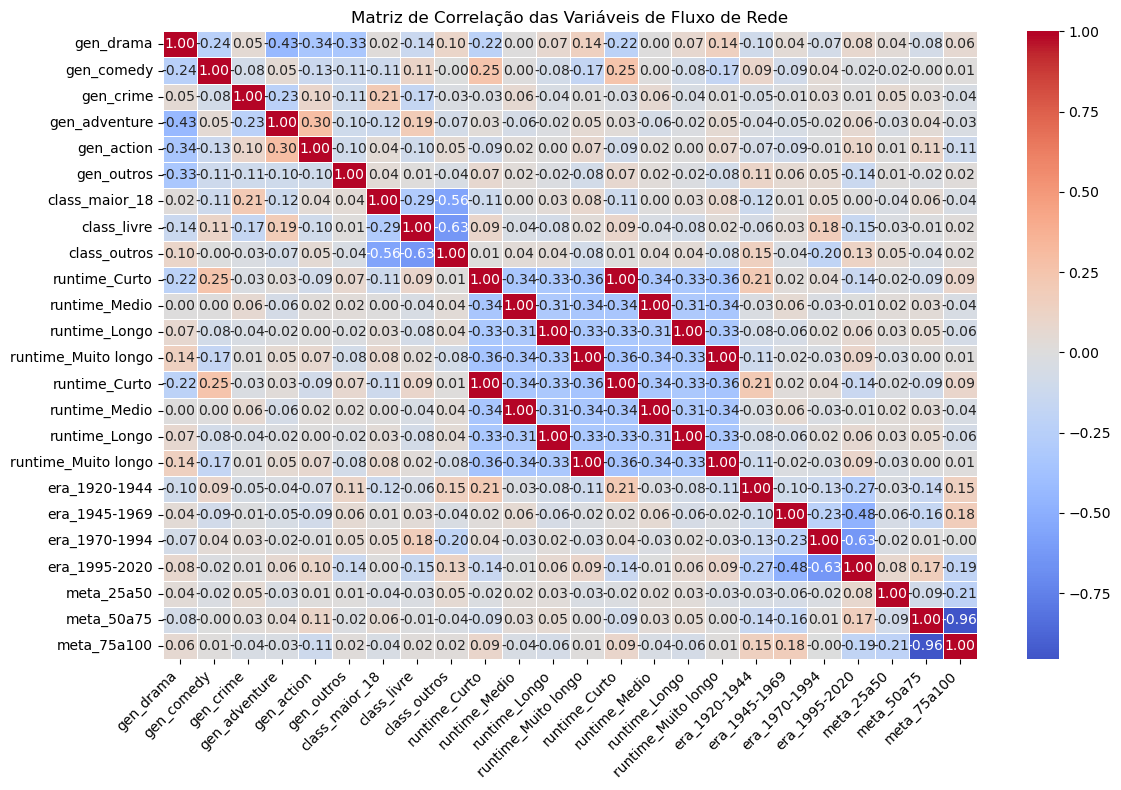

In [14]:
# Seleciona apenas colunas relevantes
df_heatmap = df.drop(columns=['IMDB_Rating']).copy()

# Matriz de correlação de Pearson
correlation_matrix = df_heatmap.corr(method='pearson')  

plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, center=0)
plt.title("Matriz de Correlação das Variáveis de Fluxo de Rede")
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

**Conclusões:**

A matriz de correlação, gerada após a etapa de engenharia de features, confirma um bom dataset para a modelagem. Não foram identificadas correlações fortes entre variáveis independentes distintas, o que minimiza o risco de multicolinearidade prejudicial ao modelo. As correlações negativas acentuadas são um resultado esperado da binarização de categorias (como 'curto' vs. 'longo') e não representam uma redundância problemática. Dessa forma, o conjunto de dados está apto para ser utilizado no treinamento do algoritmo de aprendizado de máquina.

#### Aplicação do Modelo de Máquina Supervisionado - LinearRegression

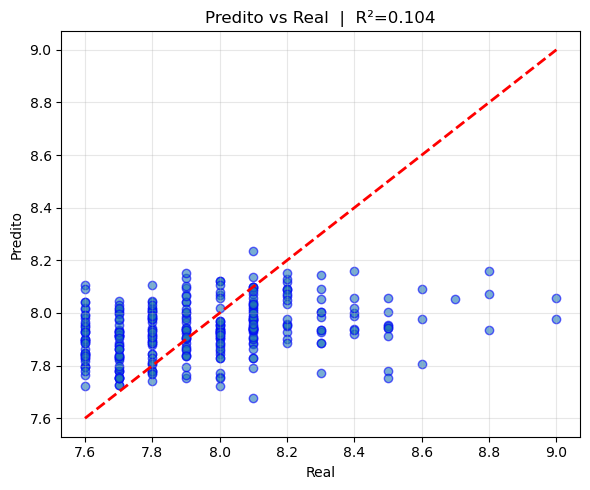

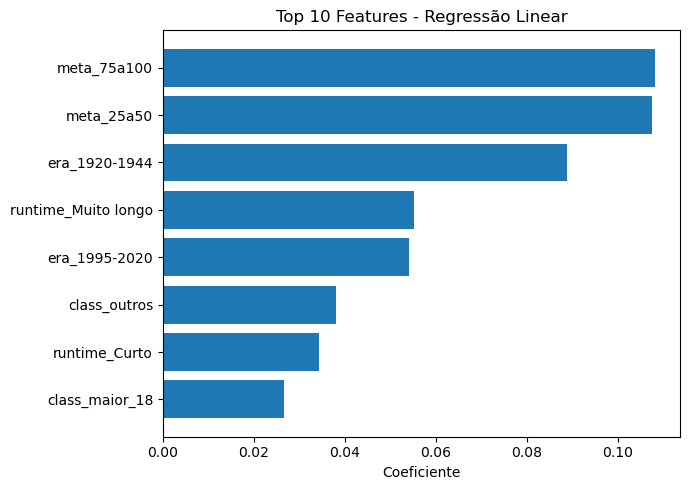

MODELO: Linear Regression
Métrica              Treino          Teste
MAE                  0.1977         0.2015
RMSE                 0.2503         0.2619
R²                   0.1420         0.1040


In [42]:
#### Aplicação do Modelo de Máquina Supervisionado - LinearRegression

#copia
df = df.copy()

#Target
y = pd.to_numeric(df['IMDB_Rating'], errors="coerce")
# Features
X = df.drop(columns=['IMDB_Rating'])

# # Divide treino/teste 70/30
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=42, stratify=pd.cut(y, bins=5))

# Aplicando o modelo 
modelo = make_pipeline(LinearRegression())
modelo.fit(X_tr, y_tr)

# Predições
y_tr_pred = modelo.predict(X_tr)
y_te_pred = modelo.predict(X_te)

# Métricas
train_mae  = mean_absolute_error(y_tr, y_tr_pred)
test_mae   = mean_absolute_error(y_te, y_te_pred)
train_rmse = np.sqrt(mean_squared_error(y_tr, y_tr_pred))
test_rmse  = np.sqrt(mean_squared_error(y_te, y_te_pred))
train_r2   = r2_score(y_tr, y_tr_pred)
test_r2    = r2_score(y_te, y_te_pred)


# Coeficientes
lr = modelo.named_steps["linearregression"]
coef_df = (pd.Series(lr.coef_, index=X.columns, name="coef")
      .to_frame().assign(abs=lambda d: d["coef"].abs())
      .sort_values("abs", ascending=False))

# Predito vs Real 
plt.figure(figsize=(6,5))
plt.scatter(y_te, y_te_pred, alpha=0.6,edgecolors='blue')
lims = [min(y_te.min(), y_te_pred.min()), max(y_te.max(), y_te_pred.max())]
plt.plot(lims, lims, "r--", lw=2)
plt.title(f"Predito vs Real  |  R²={test_r2:.3f}")
plt.xlabel("Real"); plt.ylabel("Predito")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# Top 10 features
plt.figure(figsize=(7,5))
top10 = coef_df.head(10).copy()
top10 = top10.sort_values("abs", ascending=True)  
plt.barh(top10.index, top10["abs"])              
plt.xlim(0, top10["abs"].max()*1.05)             
plt.title("Top 10 Features - Regressão Linear")
plt.xlabel("Coeficiente")
plt.tight_layout(); plt.show()

#Métricas
print(f"MODELO: {'Linear Regression'}")
print(f"{'Métrica':<12}{'Treino':>15}{'Teste':>15}")
print(f"{'MAE':<12}{train_mae:>15.4f}{test_mae:>15.4f}")
print(f"{'RMSE':<12}{train_rmse:>15.4f}{test_rmse:>15.4f}")
print(f"{'R²':<12}{train_r2:>15.4f}{test_r2:>15.4f}")



**Conclusões**

- Com base neste modelo obteve-se:

- R² (teste) = 0,104 indica que o  modelo linear explica 10,4% da variância. 

- O Erro MAE aproximadamente 0,20 e RMSE aproximadamente 0,26. Indica que treino e teste são parecidos(houve uma generalização), porém com poder preditivo limitado.

- O gráfico Predito vs Real mostra a subestimação nas notas mais altas. 

No geral a regressão linear pega pouco do sinal e tende a puxar as previsões para a média.

#### Aplicação do Modelo de Máquina Supervisionado - RandomForest

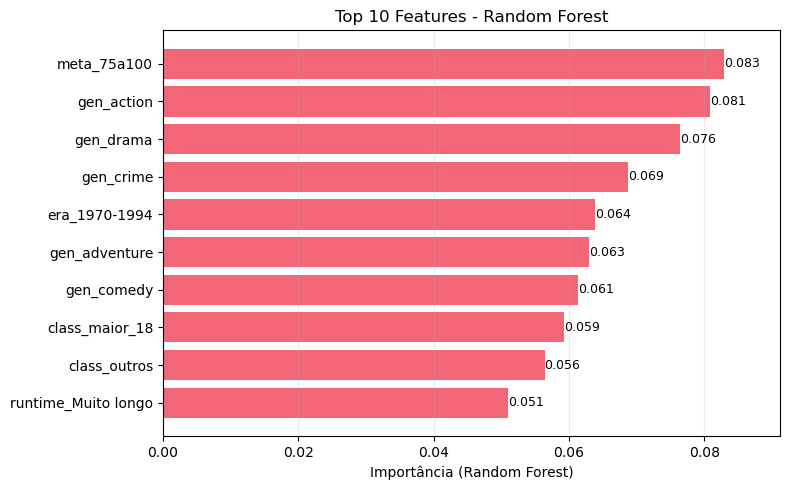

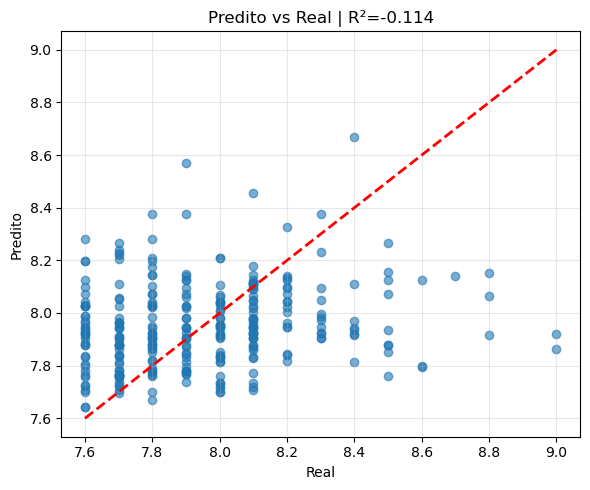

MODELO: RandomForestRegressor
Métrica              Treino          Teste
MAE                  0.1366         0.2224
RMSE                 0.1815         0.2920
R²                   0.5487        -0.1140


In [55]:
#### Aplicação do Modelo de Máquina Supervisionado - RandomForest

#Target
y = pd.to_numeric(df['IMDB_Rating'], errors="coerce")
# Features
X = df.drop(columns=['IMDB_Rating'],axis=1)


#  Divide treino/teste 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=pd.cut(y, bins=5))

# Modelo baseline
rf_baseline = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_baseline.fit(X_train, y_train)

# Predições
y_train_pred_baseline = rf_baseline.predict(X_train)
y_test_pred_baseline  = rf_baseline.predict(X_test)

# Métricas
train_r2_baseline  = r2_score(y_train, y_train_pred_baseline)
test_r2_baseline   = r2_score(y_test,  y_test_pred_baseline)
train_rmse_baseline = np.sqrt(mean_squared_error(y_train, y_train_pred_baseline))
test_rmse_baseline  = np.sqrt(mean_squared_error(y_test,  y_test_pred_baseline))
train_mae_baseline = mean_absolute_error(y_train, y_train_pred_baseline)
test_mae_baseline  = mean_absolute_error(y_test,  y_test_pred_baseline)



# Importâncias de features
feature_importance = rf_baseline.feature_importances_
feature_names = X.columns
importance_df = (pd.DataFrame({'Feature': feature_names, 'Importancia': feature_importance})
                 .sort_values('Importancia', ascending=False))

# Top 10 Feature
top10 = importance_df.head(10).iloc[::-1] 
plt.figure(figsize=(8, 5))
plt.barh(top10['Feature'], top10['Importancia'], color="#f26678")
plt.xlim(0, top10['Importancia'].max()*1.10)
plt.xlabel("Importância (Random Forest)")
plt.title("Top 10 Features - Random Forest")
plt.grid(axis="x", alpha=0.25)
for y_i, v in enumerate(top10['Importancia'].values):
    plt.text(v, y_i, f"{v:.3f}", va="center", ha="left", fontsize=9)
plt.tight_layout(); plt.show()


# Predito vs Real 
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_test_pred_baseline, alpha=0.6)
lims = [min(y_test.min(), y_test_pred_baseline.min()), max(y_test.max(), y_test_pred_baseline.max())]
plt.plot(lims, lims, "r--", lw=2)
plt.title(f"Predito vs Real | R²={test_r2_baseline:.3f}")
plt.xlabel("Real"); plt.ylabel("Predito")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

#Métricas

print("MODELO: RandomForestRegressor")
print(f"{'Métrica':<12}{'Treino':>15}{'Teste':>15}")
print(f"{'MAE':<12}{train_mae_baseline:>15.4f}{test_mae_baseline:>15.4f}")
print(f"{'RMSE':<12}{train_rmse_baseline:>15.4f}{test_rmse_baseline:>15.4f}")
print(f"{'R²':<12}{train_r2_baseline:>15.4f}{test_r2_baseline:>15.4f}")

**Conclusões**

- Com base neste modelo obteve-se:

- Treino: R² = 0.5487, MAE = 0.1366, RMSE = 0.1815

- Teste: R² = −0.1140, MAE = 0.2224, RMSE = 0.2920

Constatou-se que houve um grande overfiting, o modelo memoriza o treino (bom R²) e piora no teste (R² negativo).

** Considerações Finais**

Considerando as análises anteriores o modelo Linear Regression generaliza melhor que o Random Forest. Contudo, para colocar efetivamente em prática é necessário relizar mais testes, fazer mapeamento e testar outros modelos.

####  Perguntas

a.	Qual filme você recomendaria para uma pessoa que você não conhece?

Com base na análise explortória e seguindo a popularidade, indicaria 'The Gothefather' e/ou algum filme do gênero de Drama. Considerando a grande aceitação na amostra, tem uma boa probabilidade dela gostar.

b.	Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme? 

Como visto na base de dados, o período que foi lançado, atendar as expectativas de mercado, escolha de classificação e gênero mais populares.


c.	Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?

A coluna 'Overview' é rica em informações e dela pode-se extrair sentimentos e dependo de algumas palavras chaves é possível encontrar o gênero relacionado.


In [ ]:
# Validação

dados_filme = {
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': '1994',
    'Certificate': 'A',
    'Runtime': '142 min',
    'Genre': 'Drama',
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': '28,341,469'
}

#  Converter para DataFrame
df_filme = pd.DataFrame([dados_filme])


def preparar_amostra_nova(dados_filme_dict, X_cols):
    # DataFrame
    df_new = pd.DataFrame([dados_filme_dict]).copy()
    df_new_dum = pd.get_dummies(df_new)
    # Alinha às colunas do treino 
    X_new = df_new_dum.reindex(columns=X_cols, fill_value=0)
    return X_new

# Treino
X_new = preparar_amostra_nova(dados_filme, X.columns)

# Predição
pred_rating = rf_baseline.predict(X_new)[0]
print(f"Predição de IMDB_Rating para o filme novo: {pred_rating:.3f}")


Predição de IMDB_Rating para o filme novo: 7.777


In [76]:
import pickle

nome_do_arquivo = 'LH_CD_PRISCILA_BORGES.pkl'

with open(nome_do_arquivo, 'wb') as f:
    pickle.dump(df, f)

print(f"Objeto salvo com sucesso no arquivo '{nome_do_arquivo}'!")

Objeto salvo com sucesso no arquivo 'LH_CD_PRISCILA_BORGES.pkl'!
